In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)

import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyramid.arima import auto_arima

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

C:\Users\Yang\AppData\Local\Continuum\anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load time series
sf_day_ts = pd.read_pickle('sf_day_ts.pkl')

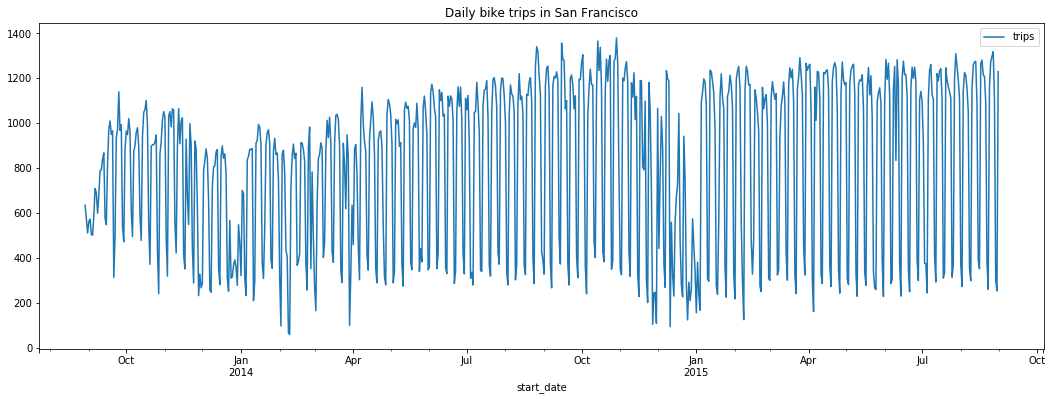

In [3]:
# Visualise the time series
sf_day_ts.plot(figsize=(18,6), title='Daily bike trips in San Francisco')

# There seems be a seasonality of lower demand around Christmas and New Year season
# Throughout the series, there are many peaks and troughs fluctuating

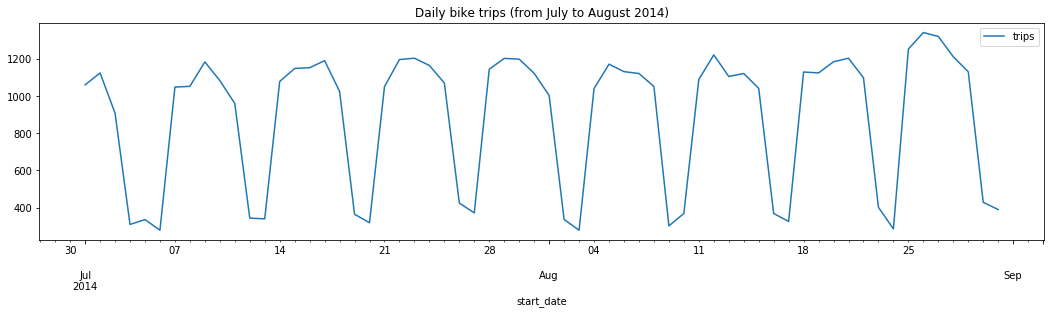

In [4]:
# Zoom in to check the peaks and troughs
sf_day_ts['2014-07':'2014-08'].plot(figsize=(18,4),\
                                    title='Daily bike trips (from July to August 2014)')

# strong seasonality over the week

<Figure size 432x288 with 0 Axes>

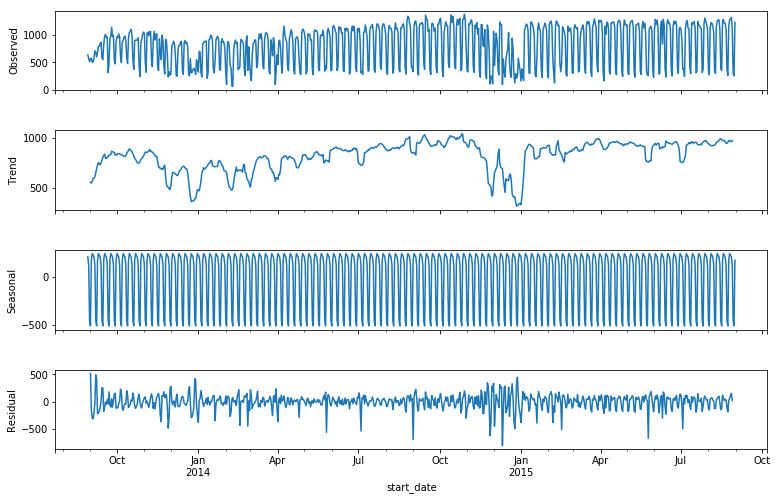

In [5]:
# Define a function to print out the seasonal decomposition chart
def decompose_chart(timeseries, freq):
    decomposition = seasonal_decompose(timeseries.iloc[:,0], freq=freq)
    fig = plt.figure()  
    fig = decomposition.plot()  
    fig.set_size_inches(12, 8)

# Plot seasonal decomposition of 7 days frequency
decompose_chart(sf_day_ts, 7)    

# The trend line is still noisy

In [6]:
# function for plotting and implementing Augmented Dickey-Fuller test to check for stationarity
def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(25, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


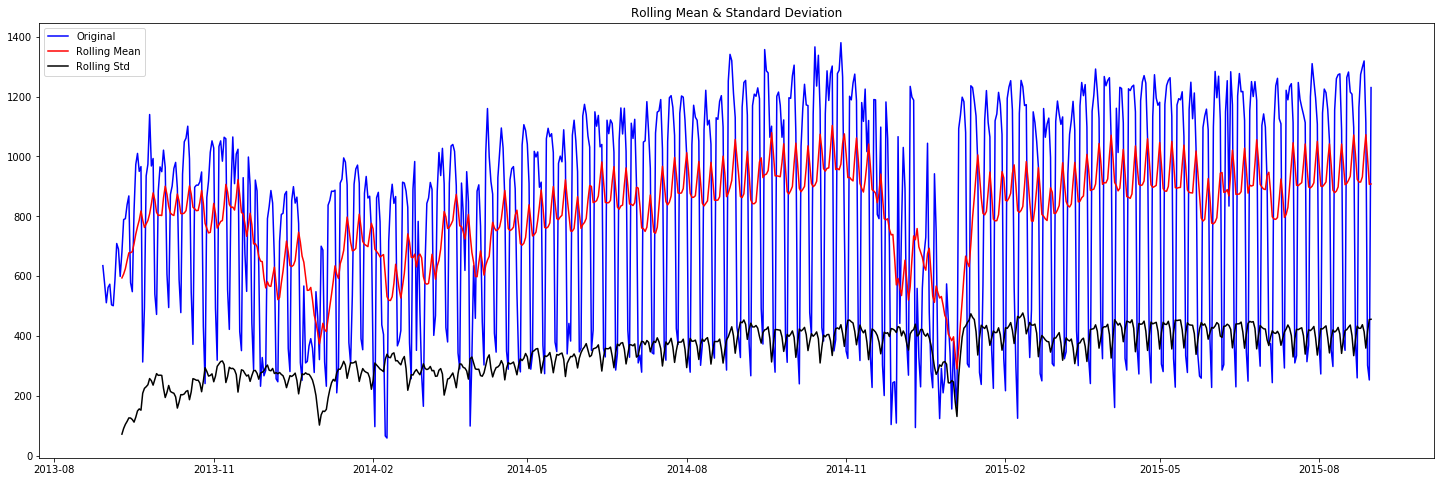

Results of Dickey-Fuller Test:
Test Statistic                  -2.290349
p-value                          0.175099
#Lags Used                      20.000000
Number of Observations Used    712.000000
Critical Value (5%)             -2.865608
Critical Value (10%)            -2.568936
Critical Value (1%)             -3.439568
dtype: float64


In [7]:
# Test stationarity on the sf time series
test_stationarity(sf_day_ts.iloc[:,0])

# As the p-value is greater than 0.05, cannot accept the null hypothesis that the 
# time series is stationary

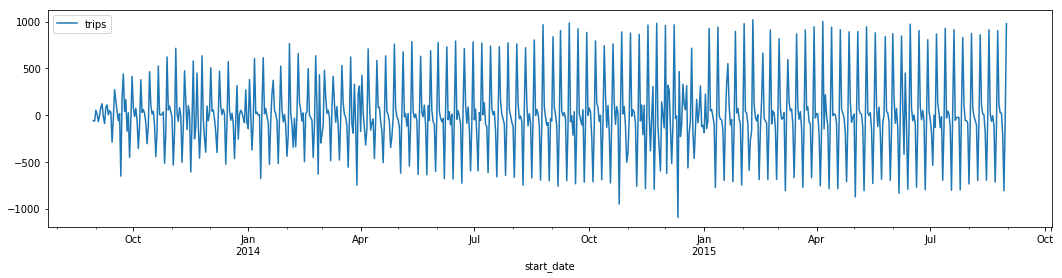

In [8]:
# Difference the time series with lag=1
sf_diff1 = sf_day_ts.diff(1)

# discard first row which has NaN value
sf_diff1 = sf_diff1.iloc[1::]

# Visualise the differenced time series
sf_diff1.plot(figsize=(18,4))

# After differencing, the annual seasonality around Christmas and New Year season 
# doesn't appear that strong anymore

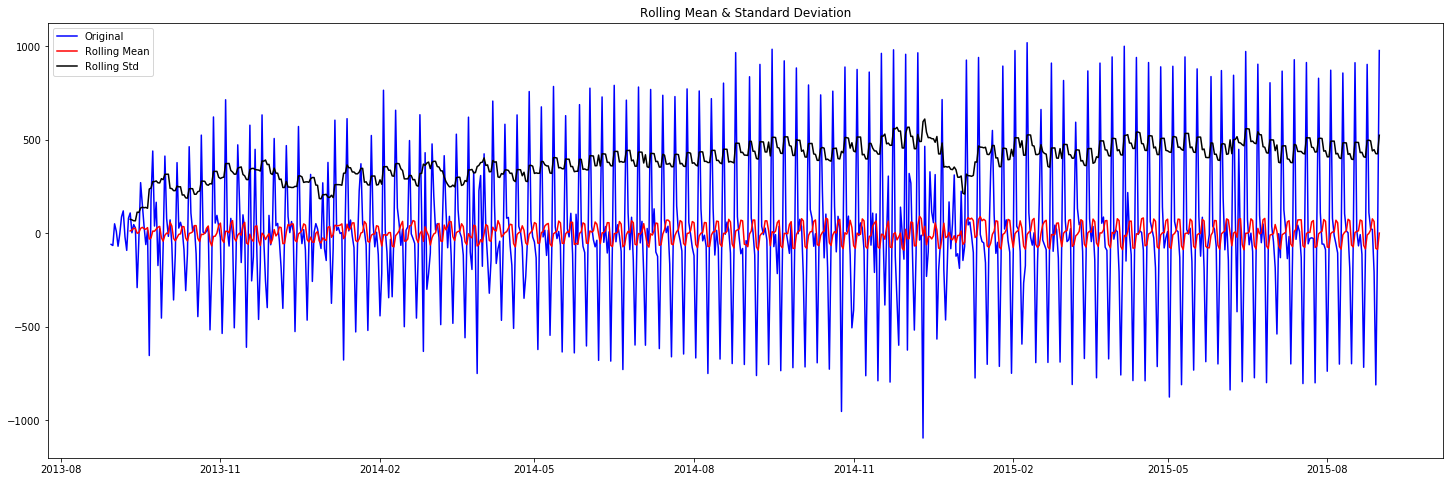

Results of Dickey-Fuller Test:
Test Statistic                -8.817386e+00
p-value                        1.917900e-14
#Lags Used                     2.000000e+01
Number of Observations Used    7.110000e+02
Critical Value (5%)           -2.865614e+00
Critical Value (10%)          -2.568939e+00
Critical Value (1%)           -3.439581e+00
dtype: float64


In [9]:
test_stationarity(sf_diff1.iloc[:,0])

The L-1 differenced time series is stationary

Hence a ARIMA model with d=1 is required

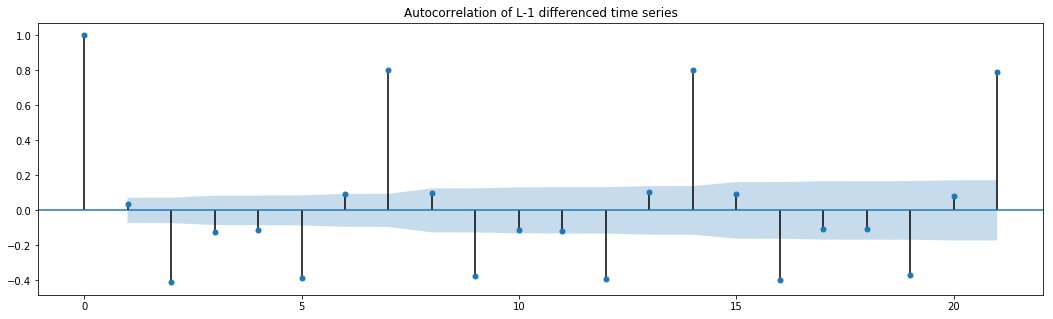

In [10]:
# Plot ACF of L-1 differenced time series
fig, ax = plt.subplots(figsize=(18,5))
plot_acf(sf_diff1, lags=21, ax=ax, title='Autocorrelation of L-1 differenced time series')
plt.show()

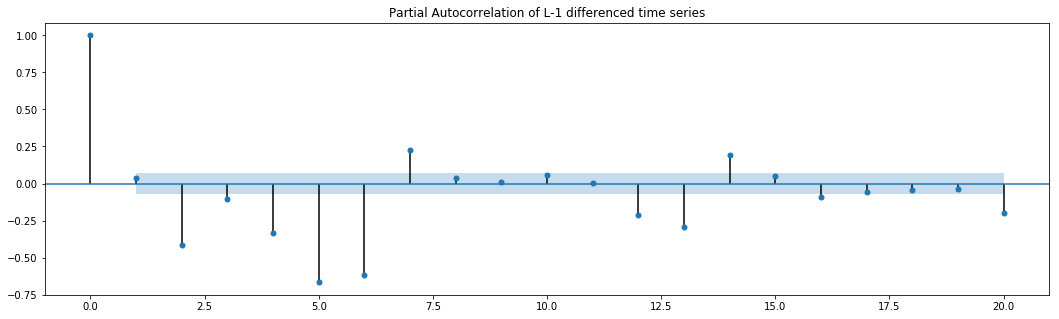

In [11]:
# Plot PACF of L-1 differenced time series
fig, ax = plt.subplots(figsize=(18,5))
plot_pacf(sf_diff1, lags=20, ax=ax, title='Partial Autocorrelation of L-1 differenced time series')
plt.show()

# a seasonal difference is also required

From the ACF and PACF plots, an AR and MA term each are probably required.  A seasonal difference is probably also required to address the weekly seasonality

### Use auto_arima function from pyramid package to find the parameters for a SARIMA model  
The d parameter is set to 1 for a first order differencing to make the time series stationary and the D parameter is also set to 1 for a seasonal differencing

In [12]:
# Tune a SARIMA model on the time series with seasonality of 7 days
p_range = [0, 7]     # start_p and max_p
d_range = [1, 2]     # d and max_d
# set min d = 1 in order to make a minimum first order differencing for stationarity of time series
q_range = [0, 3]     # start_q and max_q
P_range = [0, 2]     # start_P and max_P
D_range = [1, 2]  # D and max_D
# set min D = 1 in order to make a seasonal difference to remove seasonality
Q_range = [0, 2]     # start_Q and max_Q
m = 7                # period for seasonal differencing

stepwise_fit = auto_arima(sf_day_ts,\
                          start_p=p_range[0], d=d_range[0], start_q=q_range[0], max_p=p_range[1], max_d=d_range[1], max_q=q_range[1],\
                          start_P=P_range[0], D=D_range[0], start_Q=Q_range[0], max_P=P_range[1], max_D=D_range[1], max_Q=Q_range[1],\
                          m=m, n_jobs=-1, error_action='ignore', suppress_warnings=True, stepwise=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  733
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -4685.883
Date:                           Thu, 17 May 2018   AIC                           9381.766
Time:                                   16:32:20   BIC                           9404.752
Sample:                                        0   HQIC                          9390.632
                                           - 733                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0054      0.066     -0.082      0.935      -0.134       0.124
ar.L1          0.4031      0.029     13.820      0.000       0.346       0.460
ma.L1         -0.9220      0.015    -61.113      0.000      -0.952      -0.892
ma.S.L7       -0.8934      0.015    -61.109      0.000      -0.922      -0.865
sigma2      2.362e+04    763.345     30.936      0.000    2.21e+04    2.51e+04
===================================================================================
Ljung-Box (Q):                       69.08   Jarque-Bera (JB):              1669.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.64
Prob(H) (two-sided):                  0.98   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Define a function that takes in SARIMA parameters, time series data and a forecast start date
# The function splits the time series into train and test set using the forecast start date, 
# fits a SARIMAX model with the parameters, forecasts over the test data period and calculates the
# mean_squared_error between the forecast vs test data.
# Exogenous variables are optionally be passed in for a SARIMAX model

def trips_forecast(timeseries, p, d, q, P, D, Q, m, start_forecast_date, exo_var=None, trend=None):
    # Transform the start_forecast_date into datetime object
    delta = pd.Timedelta(days=1)  # L-1 difference
    forecast = datetime.strptime(start_forecast_date, '%Y-%m-%d')

    # Setting up the train and test split for target variable
    y = timeseries['2013-09-01'::].copy()  # start from Sep 1st, 2013
    y_train = y['2013-09-01':(forecast-delta).date()]
    y_test = y[forecast.date()::]

    train_size = np.round(float(len(y_train))/len(y),decimals=2)
    print('='*50)
    print('Train-Test split: {} - {}'.format(train_size, np.round(1-train_size, decimals=2)))
    print('='*50)
    print(' ')

    # Setting up the train, test split for the exogenous variables
    if exo_var is None:
        exo_var_train = None
        exo_var_test = None
    else:
        exo_var_train = exo_var['2013-09-01':(forecast-delta).date()].copy()
        exo_var_test  = exo_var[forecast.date()::].copy()
    
    # Fit the SARIMAX model
    model = SARIMAX(y_train, exog=exo_var_train, trend=trend, order=(p,d,q), seasonal_order=(P,D,Q,m))
    results = model.fit()
    print(results.summary())
    
    # Forecast over the test data period to compare predicted values vs actual values
    pred = results.forecast(len(y_test), exog=exo_var_test).astype('int32')
    
    # Calculate the absolute error in the prediction vs actual number of trips
    abs_error = (y_test.iloc[:,0] - pred).abs()

    # Calculate the percentage error = absolute_error / actual trips
    percent_error = abs_error / y_test.iloc[:,0]

    # Plot both the actual data and forecasted data
    fig = plt.figure(figsize=(18,18))
    ax1 = fig.add_subplot(311)
    ax1.set_title('Actual number of trips vs Predicted number of trips')
    plt.plot(timeseries[forecast.date()::], 'b-', label='actual')
    plt.plot(pred, 'r--', label='predicted')
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Trips')
    ax1.legend(loc='best')

    print(' ')
    print('Forecast Period: from {}'.format(start_forecast_date))
    print('='*40)
    print('AIC score: {}'.format(results.aic))
    print('R2 score: {}'.format(r2_score(timeseries[forecast.date()::], pred)))
    print(' ')
    print('Average absolute error: {}'.format(abs_error.mean()))
    print('Average percentage error: {}'.format(percent_error.mean()))
    
    # Check the ACF and PACF plot of the residuals
    ax2 = fig.add_subplot(312)
    plot_acf(results.resid, ax=ax2, title='Autocorrelation of the residuals')
    ax3 = fig.add_subplot(313)
    plot_pacf(results.resid, ax=ax3, title='Partial autocorrelation of the residuals')
    
    return None


# Model 1 - SARIMA (1,1,1)x(0,1,1,7) 

Train-Test split: 0.79 - 0.21
 
                                 Statespace Model Results                                
Dep. Variable:                             trips   No. Observations:                  577
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -3705.673
Date:                           Thu, 17 May 2018   AIC                           7419.346
Time:                                   16:32:21   BIC                           7436.777
Sample:                               09-01-2013   HQIC                          7426.144
                                    - 03-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4333      0.034     12.920      0.000       0.368       0.499
ma.L1      

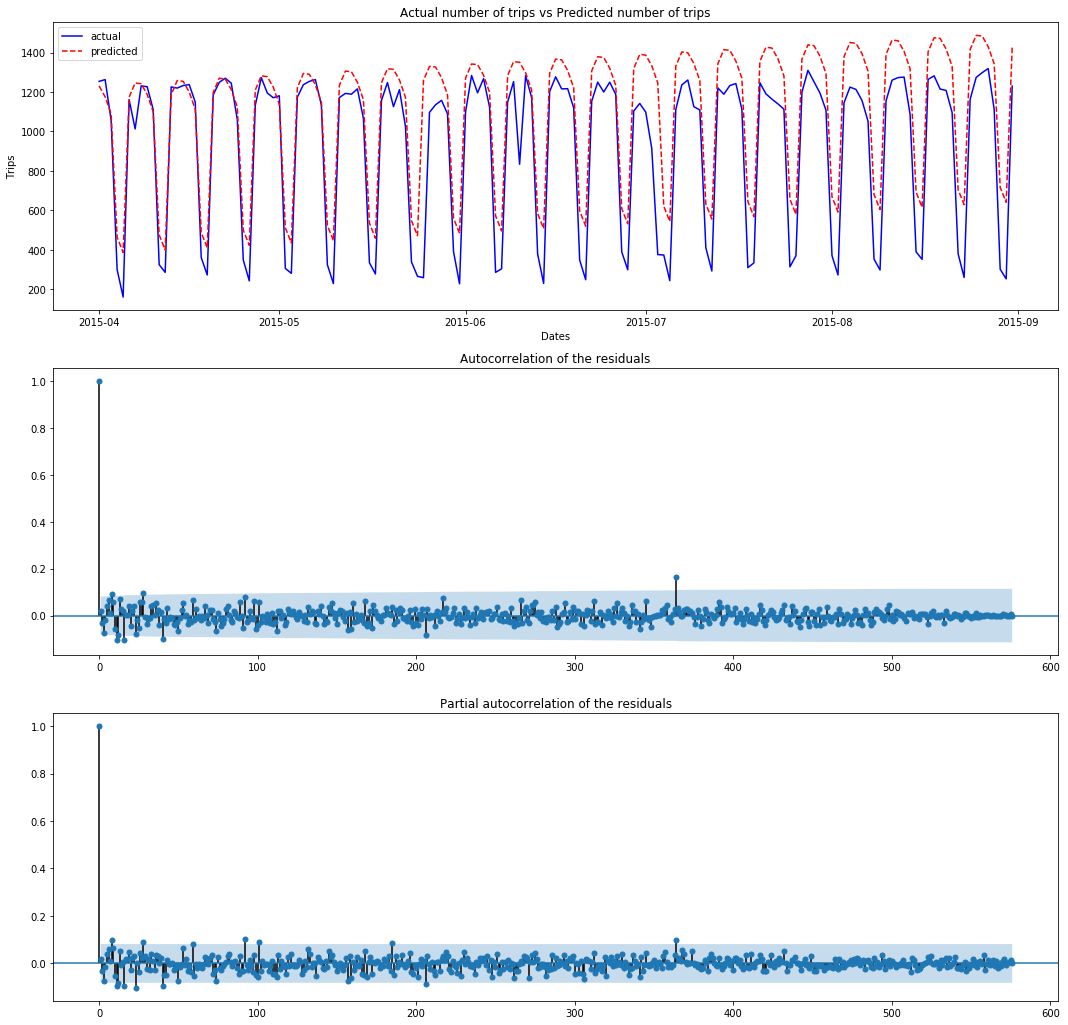

In [14]:
# Forecast from April 1st, 2015 in order to achieve a 80%-20% train-test split
trips_forecast(sf_day_ts, 1, 1, 1, 0, 1, 1, 7, '2015-04-01')

Train-Test split: 0.87 - 0.13
 
                                 Statespace Model Results                                
Dep. Variable:                             trips   No. Observations:                  638
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -4094.403
Date:                           Thu, 17 May 2018   AIC                           8196.805
Time:                                   16:32:24   BIC                           8214.639
Sample:                               09-01-2013   HQIC                          8203.728
                                    - 05-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4134      0.032     12.969      0.000       0.351       0.476
ma.L1      

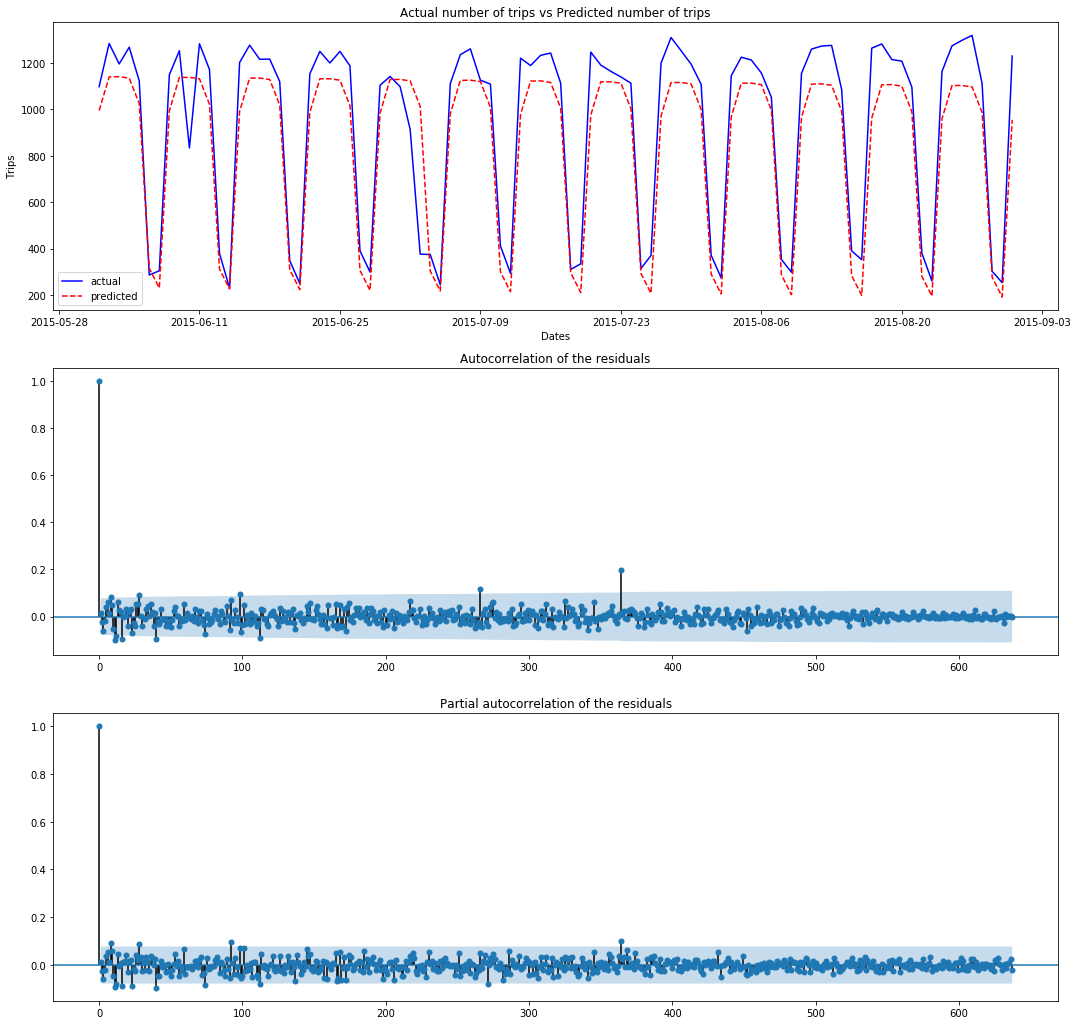

In [15]:
# Forecast from June 1st, 2015.  Assume business forecasting is quarterly, hence this would be forecasting Q3 demand
trips_forecast(sf_day_ts, 1, 1, 1, 0, 1, 1, 7, '2015-06-01')

Forecasting over shorter period is obviously more accurate than over a longer time period

# Incorporate weather data as exogenous variables in a SARIMAX model

In [16]:
# Load weather data from the pickled file
sf_weather = pd.read_pickle('sf_weather.pkl')
sf_weather = sf_weather.set_index('date')

In [17]:
# Join the weather data to original time series to better check the correlation between them
sf_exo = sf_day_ts.join(sf_weather)


In [18]:
# Calculate the correlation of each weather variable vs the target variable, trips
corr_vector = sf_exo.corr()['trips'].copy().sort_values(axis=0, ascending=False)

corr_vector


trips                             1.000000
max_temperature_f                 0.226480
mean_temperature_f                0.217507
min_temperature_f                 0.161461
wind_dir_degrees                  0.151235
mean_dew_point_f                  0.140905
max_dew_point_f                   0.137303
min_dew_point_f                   0.137039
min_visibility_miles              0.098703
mean_visibility_miles             0.098284
mean_wind_speed_mph               0.010182
Thunderstorm                     -0.011694
max_gust_speed_mph               -0.021823
max_wind_Speed_mph               -0.029640
max_visibility_miles             -0.029670
Fog                              -0.041015
cloud_cover                      -0.042396
max_humidity                     -0.056341
min_sea_level_pressure_inches    -0.060622
min_humidity                     -0.069423
mean_humidity                    -0.071567
mean_sea_level_pressure_inches   -0.084425
max_sea_level_pressure_inches    -0.106981
Rain       

Select max_temperature_f and precipitation_inches as the exogenous variables because they have the highest absolute correlation value.  
mean_temperature_f is skipped as it is likely to be highly correlated to max_temperature_f 

In [19]:
exo_list = ['max_temperature_f', 'precipitation_inches']

 
Check stationarity of variable: max_temperature_f


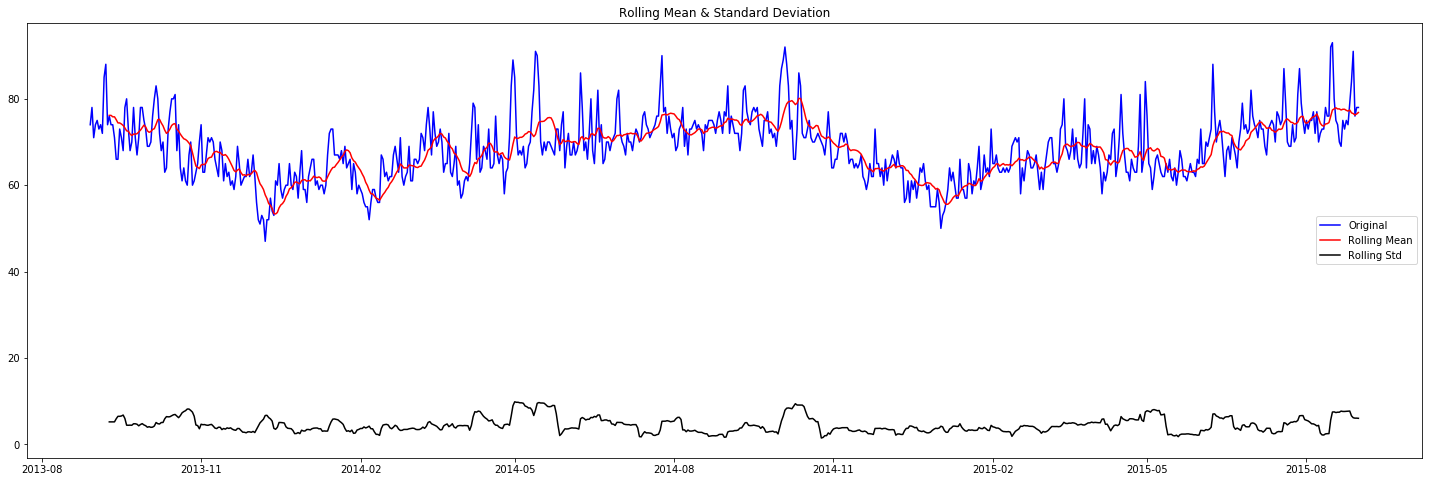

Results of Dickey-Fuller Test:
Test Statistic                  -2.934477
p-value                          0.041483
#Lags Used                      11.000000
Number of Observations Used    721.000000
Critical Value (5%)             -2.865557
Critical Value (10%)            -2.568909
Critical Value (1%)             -3.439452
dtype: float64
 
Check stationarity of variable: precipitation_inches


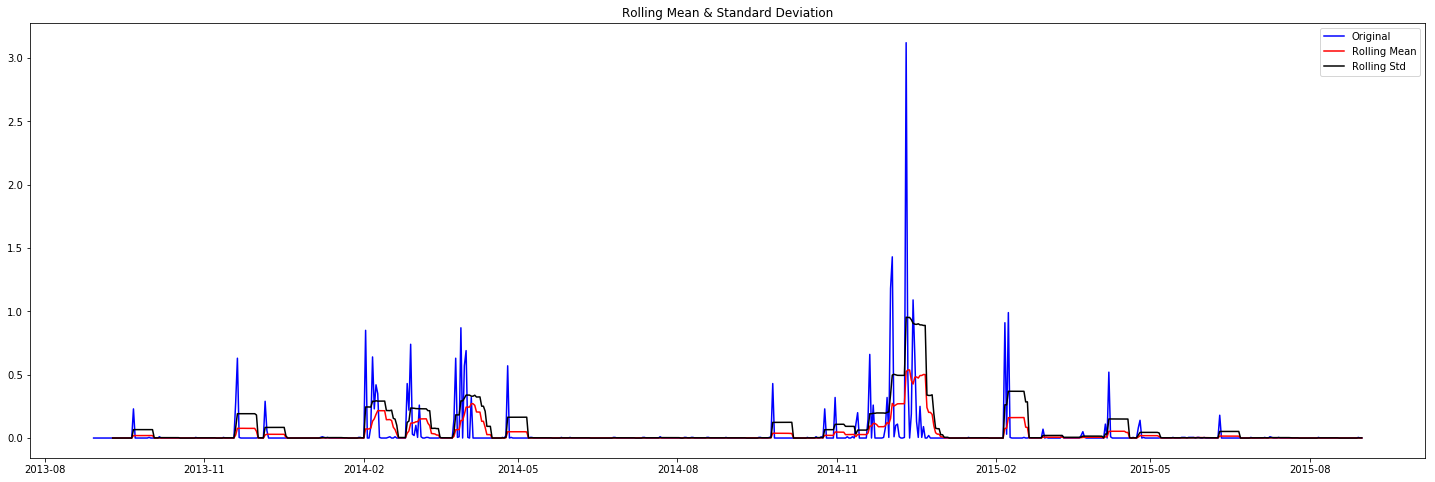

Results of Dickey-Fuller Test:
Test Statistic                -5.792949e+00
p-value                        4.824682e-07
#Lags Used                     8.000000e+00
Number of Observations Used    7.240000e+02
Critical Value (5%)           -2.865540e+00
Critical Value (10%)          -2.568900e+00
Critical Value (1%)           -3.439414e+00
dtype: float64


In [20]:
# Check stationarity of each of the exogenous variables

for var in exo_list:
    print(' ')
    print('Check stationarity of variable: {}'.format(var))
    test_stationarity(sf_exo.loc[:,var])
    print('='*50)

The p-values for both exogenous variables for the ADF test are less than 0.05, hence they are stationary

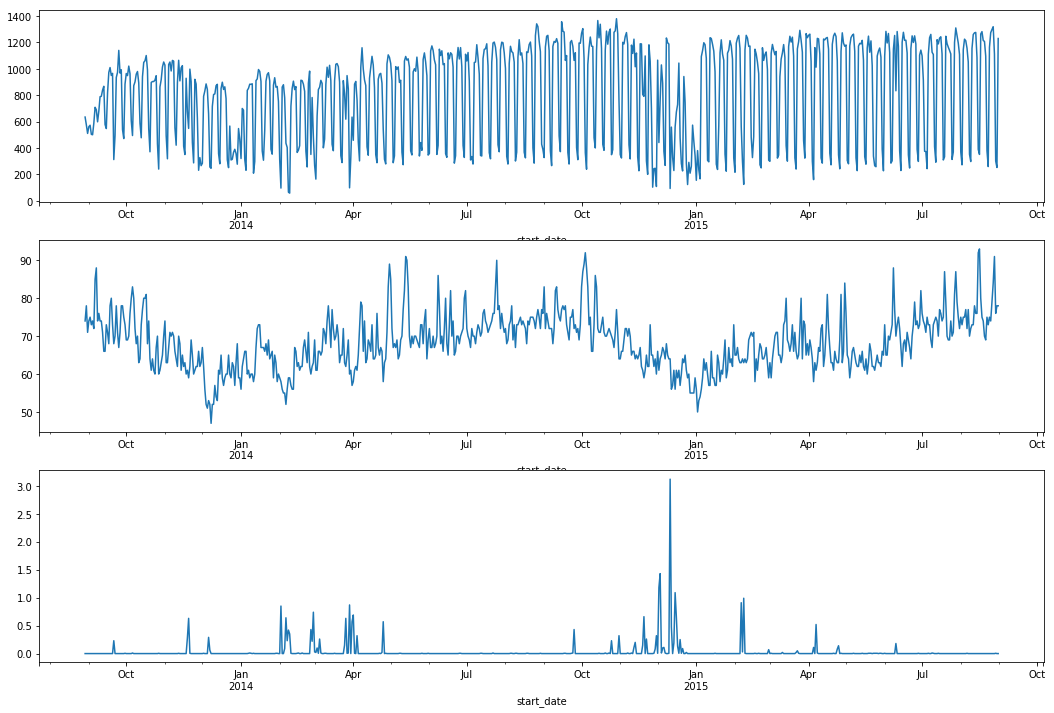

In [21]:
# Visualise the trips time series together with the 2 exogenous variable
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(311)
sf_exo['trips'].plot(ax=ax1)
ax2 = fig.add_subplot(312)
sf_exo['max_temperature_f'].plot(ax=ax2)
ax3 = fig.add_subplot(313)
sf_exo['precipitation_inches'].plot(ax=ax3)


In [22]:
# set up the exogenous variables to pass into auto_arima
exo_var = sf_exo[exo_list].copy()

# target (y) variable
y_exo = pd.DataFrame(sf_exo['trips'])

In [23]:
# Tune a SARIMAX model (min_d=1 to difference the time series and add exogenous variables
p_range = [0, 7]     # start_p and max_p
d_range = [1, 2]     # d and max_d
# set min_d = 1 to difference at least once the time series
q_range = [0, 3]     # start_q and max_q
P_range = [0, 2]     # start_P and max_P
D_range = [1, 2]     # D and max_D
# set min D = 1 in order to make a seasonal difference to remove seasonality
Q_range = [0, 3]     # start_Q and max_Q
m = 7                # period for seasonal differencing


stepwise_fit_exo = auto_arima(y_exo, exogenous=exo_var,\
                       start_p=p_range[0], d=d_range[0], start_q=q_range[0], max_p=p_range[1], max_d=d_range[1], max_q=q_range[1],\
                       start_P=P_range[0], D=D_range[0], start_Q=Q_range[0], max_P=P_range[1], max_D=D_range[1], max_Q=Q_range[1],\
                       m=m, n_jobs=-1, error_action='ignore', suppress_warnings=True, stepwise=True)

stepwise_fit_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  733
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -4602.876
Date:                           Thu, 17 May 2018   AIC                           9223.752
Time:                                   16:33:30   BIC                           9265.126
Sample:                                        0   HQIC                          9239.711
                                           - 733                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.005     -0.189      0.850      -0.011       0.009
x1             4.0779      1.196      3.409      0.001       1.734       6.422
x2          -375.6676     21.016    -17.875      0.000    -416.858    -334.477
ar.L1          0.5187      0.020     26.116      0.000       0.480       0.558
ma.L1         -0.9998      0.110     -9.118      0.000      -1.215      -0.785
ar.S.L7        0.1348      0.033      4.060      0.000       0.070       0.200
ar.S.L14      -0.0658      0.038     -1.711      0.087      -0.141       0.010
ma.S.L7       -0.8880      0.026    -33.733      0.000      -0.940      -0.836
sigma2      1.866e+04   1992.150      9.369      0.000    1.48e+04    2.26e+04
===================================================================================
Ljung-Box (Q):                       72.44   Jarque-Bera (JB):              2793.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -1.80
Prob(H) (two-sided):                  0.22   Kurtosis:                        11.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model 2 - SARIMAX (1,1,1)x(1,1,1,7)  

Although the auto_arima function recommends a AR.S.L14 term, the p-value is greater than 0.05 which means that the auto-correlation is not statistically significant

Train-Test split: 0.79 - 0.21
 
                                 Statespace Model Results                                
Dep. Variable:                             trips   No. Observations:                  577
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3633.462
Date:                           Thu, 17 May 2018   AIC                           7280.924
Time:                                   16:33:32   BIC                           7311.429
Sample:                               09-01-2013   HQIC                          7292.820
                                    - 03-31-2015                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
max_temperature_f        4.5003      1.416      3.177      0.001      

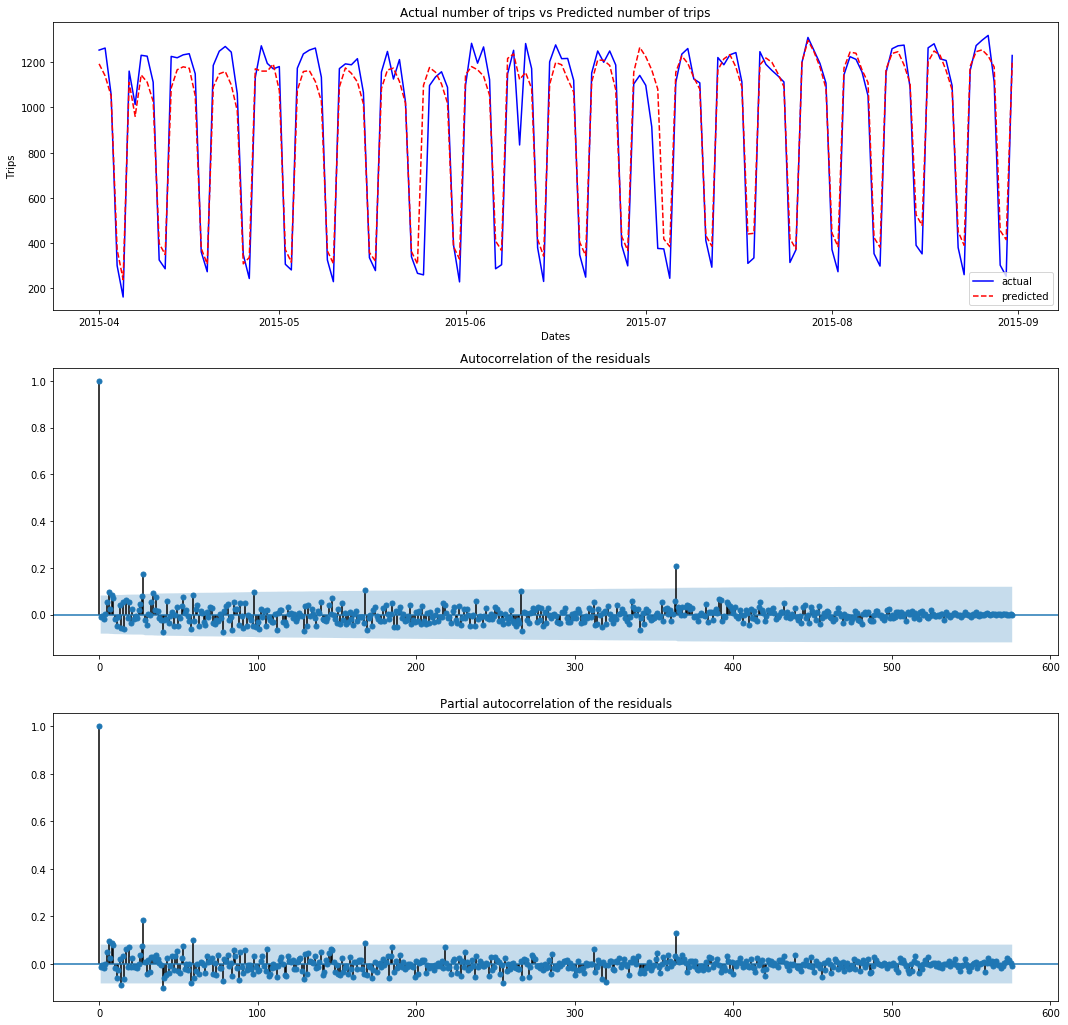

In [24]:
# Forecast from April 1st, 2015
trips_forecast(y_exo, 1, 1, 1, 1, 1, 1, 7, '2015-04-01', exo_var=exo_var)

Train-Test split: 0.87 - 0.13
 
                                 Statespace Model Results                                
Dep. Variable:                             trips   No. Observations:                  638
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4019.092
Date:                           Thu, 17 May 2018   AIC                           8052.185
Time:                                   16:33:36   BIC                           8083.393
Sample:                               09-01-2013   HQIC                          8064.300
                                    - 05-31-2015                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
max_temperature_f        4.2216      1.355      3.116      0.002      

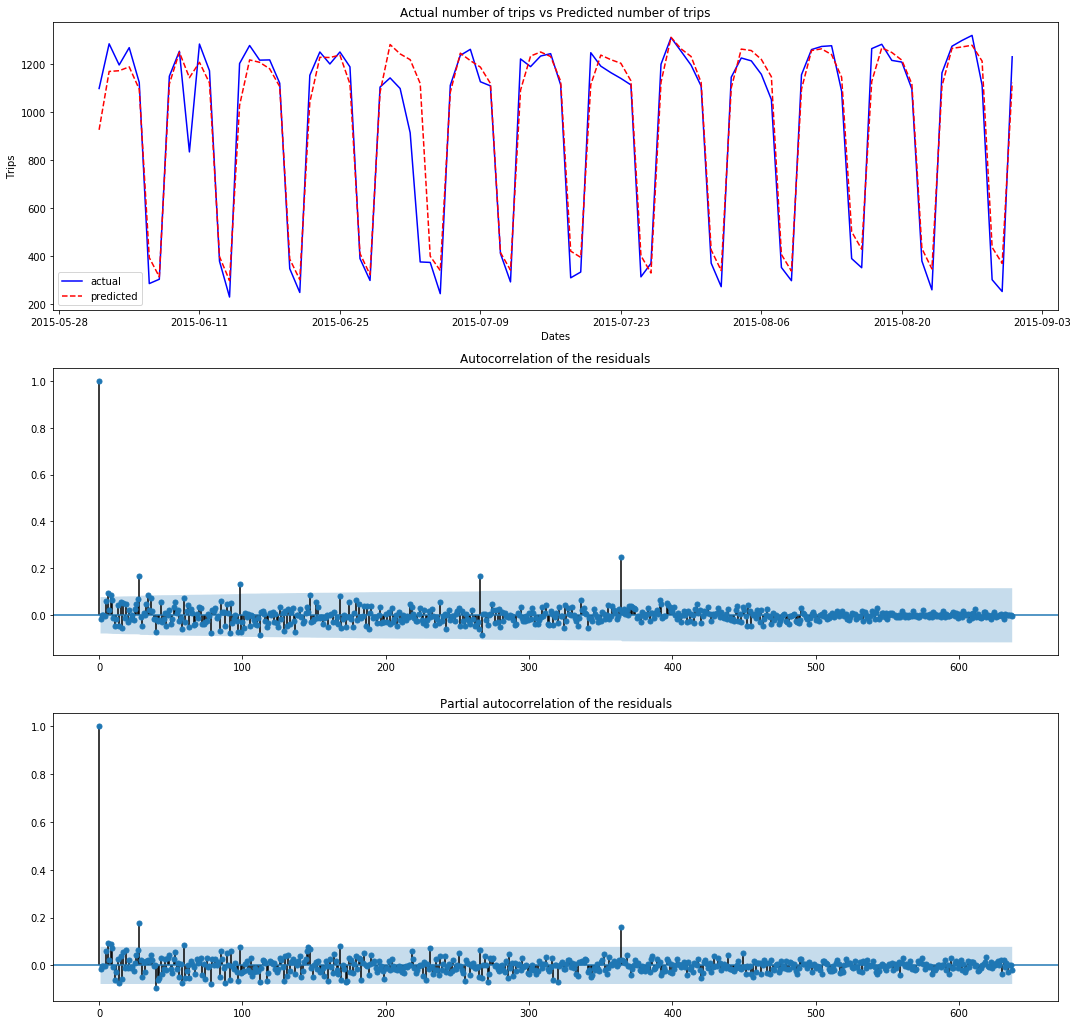

In [25]:
# Forecast from June 1st, 2015 using Model 2
trips_forecast(y_exo, 1, 1, 1, 1, 1, 1, 7, '2015-06-01', exo_var=exo_var)

### Try a SARIMAX model with seasonality of 28 weeks (monthly) 

In [26]:
# Tune a SARIMAX model (min_d=1 to difference the time series and add exogenous variables
p_range = [0, 7]     # start_p and max_p
d_range = [1, 2]     # d and max_d
# set min_d = 1 to difference at least once the time series
q_range = [0, 3]     # start_q and max_q
P_range = [0, 2]     # start_P and max_P
D_range = [1, 2]     # D and max_D
# set min D = 1 in order to make a seasonal difference to remove seasonality
Q_range = [0, 3]     # start_Q and max_Q
m = 28               # period for seasonal differencing


stepwise_fit_exo = auto_arima(y_exo, exogenous=exo_var,\
                       start_p=p_range[0], d=d_range[0], start_q=q_range[0], max_p=p_range[1], max_d=d_range[1], max_q=q_range[1],\
                       start_P=P_range[0], D=D_range[0], start_Q=Q_range[0], max_P=P_range[1], max_D=D_range[1], max_Q=Q_range[1],\
                       m=m, n_jobs=-1, error_action='ignore', suppress_warnings=True, stepwise=True)

stepwise_fit_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  733
Model:             SARIMAX(1, 1, 1)x(1, 1, 2, 28)   Log Likelihood               -4516.326
Date:                            Thu, 17 May 2018   AIC                           9050.651
Time:                                    16:53:58   BIC                           9092.025
Sample:                                         0   HQIC                          9066.611
                                            - 733                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0152      0.084     -0.182      0.856      -0.179       0.149
x1             3.7510      1.301      2.884      0.004       1.201       6.301
x2          -358.1651     25.567    -14.009      0.000    -408.276    -308.054
ar.L1          0.4437      0.031     14.189      0.000       0.382       0.505
ma.L1         -0.9376      0.015    -61.413      0.000      -0.968      -0.908
ar.S.L28       0.2303      0.306      0.753      0.451      -0.369       0.829
ma.S.L28      -0.9197      0.312     -2.946      0.003      -1.532      -0.308
ma.S.L56       0.0717      0.242      0.296      0.767      -0.403       0.546
sigma2      2.104e+04    791.862     26.573      0.000    1.95e+04    2.26e+04
===================================================================================
Ljung-Box (Q):                       98.08   Jarque-Bera (JB):               949.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -1.01
Prob(H) (two-sided):                  0.11   Kurtosis:                         8.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model 3 - SARIMAX (1,1,1)x(0,1,1,28)  
Reduce ar.S.L28 (P) to zero and ma.S.L56 (Q) to 1 as the p-values of the 2 terms indicate the autocorrelation are not statistically significant

Train-Test split: 0.79 - 0.21
 
                                 Statespace Model Results                                 
Dep. Variable:                              trips   No. Observations:                  577
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 28)   Log Likelihood               -3537.368
Date:                            Thu, 17 May 2018   AIC                           7086.737
Time:                                    16:54:07   BIC                           7112.884
Sample:                                09-01-2013   HQIC                          7096.933
                                     - 03-31-2015                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
max_temperature_f        5.9140      1.330      4.446      0.0

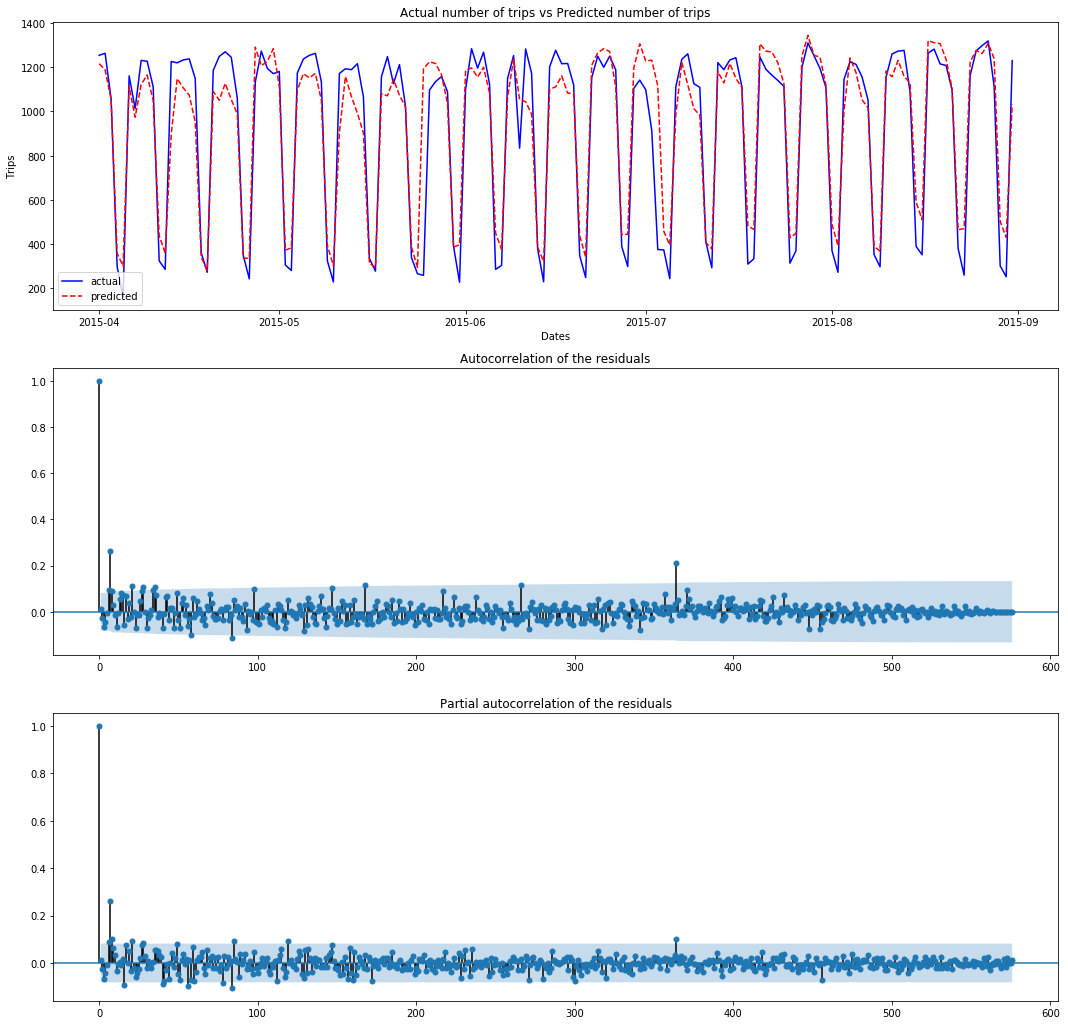

In [27]:
# Forecast from April 1st, 2015
trips_forecast(y_exo, 1, 1, 1, 0, 1, 1, 28, '2015-04-01', exo_var=exo_var)

Train-Test split: 0.87 - 0.13
 
                                 Statespace Model Results                                 
Dep. Variable:                              trips   No. Observations:                  638
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 28)   Log Likelihood               -3932.360
Date:                            Thu, 17 May 2018   AIC                           7876.720
Time:                                    16:54:22   BIC                           7903.470
Sample:                                09-01-2013   HQIC                          7887.104
                                     - 05-31-2015                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
max_temperature_f        5.7812      1.255      4.607      0.0

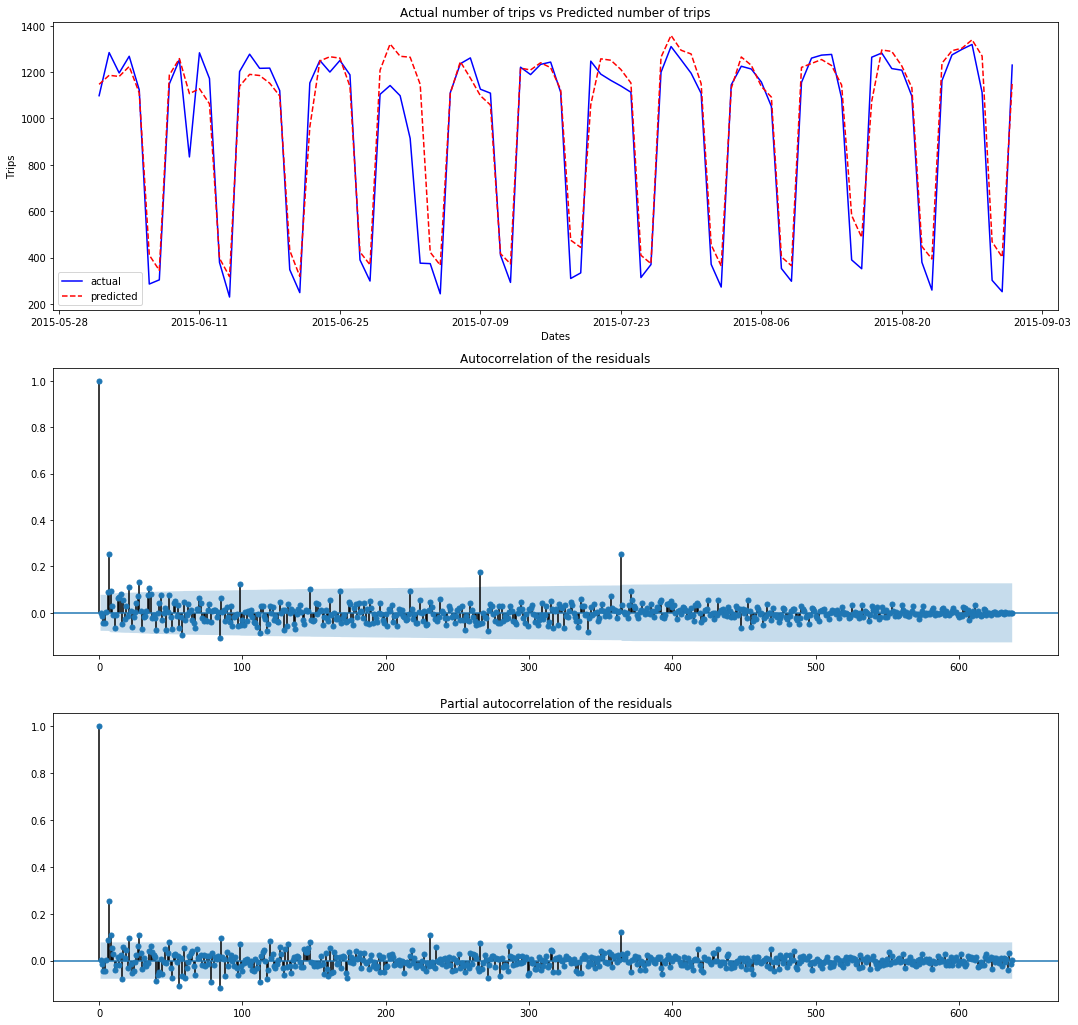

In [28]:
# Forecast from June 1st, 2015
trips_forecast(y_exo, 1, 1, 1, 0, 1, 1, 28, '2015-06-01', exo_var=exo_var)

The ACF and PACF plots show that the SARIMAX at seasonal order of 28 days failed to capture the seasonality at 7 days

## Summary of results

   |SARIMA (1,1,1)x(0,1,1,7)|SARIMAX (S7) (1,1,1)x(1,1,1,7)|SARIMAX (S28) (1,1,1)x(0,1,1,28)
:----:|:----------------:|:--------------------:|:----------------:
Apr-1 |AIC = 7419        |AIC = 7280            |**AIC = 7086**
      |R2 = 0.71         |**R2 = 0.91**         |R2 = 0.87
      |Avg AbsErr = 175  |**Avg AbsErr = 75**   |Avg AbsErr = 99
      |Avg %AbsErr = 35% |**Avg %AbsErr = 14%** |Avg %AbsErr = 18% 
Jun-1 |AIC = 8197        |AIC = 8052            |**AIC = 7877**
      |R2 = 0.86         |**R2 = 0.92**         |R2 = 0.90
      |Avg AbsErr = 121  |**Avg AbsErr = 68**   |Avg AbsErr = 79
      |Avg %AbsErr = 15% |**Avg %AbsErr = 12%** |Avg %AbsErr = 14% 


## Findings  
- The models' performance were compared with various metrics - AIC, R-squared, Average Absolute Error and Average %Absolute Error.
- The SARIMAX model (with exogenous variable) at seasonality = 7 days performed best for metrics, R-squared and average absolute error and average %absolute error.
- For business, the accuracy of daily forecast is most important, hence I consider the absolute error and absolute error as a percentage of the actual value to be most relevant.
- Especially in the longer forecast period, the exogenous variables were able to eliminate the increasing trend observed in the SARIMA model without exogenous variables.
- Seasonal differencing of 28 days did not perform better than the model with seasonal differencing of 7 days, although the AIC scores were lower.
- Unfortunately for all models, the p-values of Ljung-Box test are zero.   
- The null hypothesis of Ljung-Box test in ARIMA models is that the residuals of the model have no autocorrelation.
- The zero p-value of Ljung-Box test means that the null hypothesis cannot be accepted, hence the residuals of the SARIMAX model are autocorrelated, the ACF and PACF plots of the residuals also validates this observation.
- If the residuals are not completely random, that means the model was unable to fit all the variance in the residuals.
- From observing the time series and the ACF and PACF plots, there appears to have other orders of seasonality like monthly and annually.
- When a SARIMAX model with seasonality order of 28 days was used, the ACF and PACF plots of the residuals showed that the weekly seasonality was not captured by the model
- Current statsmodel SARIMAX models are not able to handle seasonality of different orders.